***Projeto Engenharia do Conhecimento 2024/2025***

Notebook realizado por:
* Marcelo Munteanu fc56359
* Pedro Elias fc58435
* Pedro Junior fc54555



***O1:***

Neste objetivo precisamos de descobrir se uma pessoa faleceu conforme os atributos na tabela. No nosso entendimento para treinar um modelo para descobrir se a pessoa faleceu ou não temos de verificar primeiro os óbitos confirmados e ver as suas possiveís causas.

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import randint
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, classification_report, confusion_matrix, precision_score, recall_score,matthews_corrcoef, mean_absolute_error, mean_squared_error, r2_score

from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR



In [18]:
def plot_confusion(cm, classes, title=None):
    fig, ax = plt.subplots(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt='d', cbar=False,
                xticklabels=classes, yticklabels=classes, cmap='Blues', ax=ax)
    ax.set_ylabel('True')
    ax.set_xlabel('Predicted')
    if title:
        ax.set_title(title)
    plt.show()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 21 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   USMER           100000 non-null  int64
 1   MEDICAL_UNIT    100000 non-null  int64
 2   SEX             100000 non-null  int64
 3   PATIENT_TYPE    100000 non-null  int64
 4   INTUBED         100000 non-null  int64
 5   PNEUMONIA       100000 non-null  int64
 6   AGE             100000 non-null  int64
 7   PREGNANT        100000 non-null  int64
 8   DIABETES        100000 non-null  int64
 9   COPD            100000 non-null  int64
 10  ASTHMA          100000 non-null  int64
 11  INMSUPR         100000 non-null  int64
 12  HYPERTENSION    100000 non-null  int64
 13  OTHER_DISEASE   100000 non-null  int64
 14  CARDIOVASCULAR  100000 non-null  int64
 15  OBESITY         100000 non-null  int64
 16  RENAL_CHRONIC   100000 non-null  int64
 17  TOBACCO         100000 non-null  int64
 18  TEST_

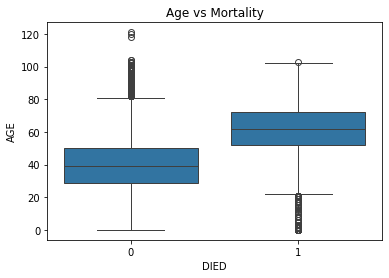

In [ ]:
df = pd.read_csv("custom_covid19.csv")
# criação de variável alvo binária
df['DIED'] = df['DATE_DIED'].apply(lambda x: 1 if x != '9999-99-99' else 0)
df.drop(columns=['DATE_DIED'], inplace=True)

df.info()
df['DIED'].value_counts(normalize=True)

# distribuiçao de idade por mortalidade
g = sns.boxplot(x='DIED', y='AGE', data=df)
g.set_title('Age vs Mortality')
plt.show()

In [ ]:
cat_cols = df.select_dtypes(include='object').columns.tolist()
num_cols = df.select_dtypes(include=['int64','float64']).drop('DIED', axis=1).columns.tolist()


for c in cat_cols:
    df[c].replace({'97': np.nan, '99': np.nan}, inplace=True)

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

In [ ]:
#divisao de dados
X = df.drop('DIED', axis=1)
y = df['DIED']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [ ]:

#regressao logistica
d = {
    'KNN': KNeighborsClassifier(),
    'DecisionTree': DecisionTreeClassifier(random_state=42),
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42)
}
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = {}
for name, model in d.items():
    pipe = Pipeline([('pre', preprocessor), ('clf', model)])
    scores = cross_val_score(pipe, X_train, y_train, cv=skf, scoring='roc_auc')
    cv_scores[name] = (scores.mean(), scores.std())
    print(f"{name:20s} CV ROC-AUC: {scores.mean():.4f} ± {scores.std():.4f}")

test_results = []
for name, (mean, _) in sorted(cv_scores.items(), key=lambda x: x[1][0], reverse=True):
    pipe = Pipeline([('pre', preprocessor), ('clf', d[name])])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    y_prob = pipe.predict_proba(X_test)[:,1]
    test_results.append({
        'Model': name,
        'Test ROC-AUC': roc_auc_score(y_test, y_prob),
        'Accuracy': accuracy_score(y_test, y_pred),
        'F1score': f1_score(y_test, y_pred)
    })


KNN                  CV ROC-AUC: 0.8814 ± 0.0026
DecisionTree         CV ROC-AUC: 0.7579 ± 0.0103
LogisticRegression   CV ROC-AUC: 0.9479 ± 0.0022


                Model  Test ROC-AUC  Accuracy  F1-score
0  LogisticRegression      0.946091   0.93620  0.476190
1                 KNN      0.890971   0.93470  0.498078
2        DecisionTree      0.755497   0.93115  0.506628

Melhor modelo: LogisticRegression
Project Test ROC-AUC: 0.9815668202764978
Accuracy: 0.94
F1-score: 0.4

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97        93
           1       0.67      0.29      0.40         7

    accuracy                           0.94       100
   macro avg       0.81      0.64      0.68       100
weighted avg       0.93      0.94      0.93       100



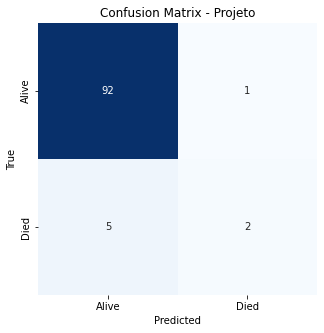

In [ ]:
import pandas as pd
test_df = pd.DataFrame(test_results).sort_values('Test ROC-AUC', ascending=False)
print(test_df)

best_name = test_df.iloc[0]['Model']
best_pipe = Pipeline([('pre', preprocessor), ('clf', d[best_name])])
best_pipe.fit(X_train, y_train)
print(f"\nmelhor modelo: {best_name}")

proj_X = pd.read_csv('proj-test-data.csv')
proj_y = pd.read_csv('proj-test-class.csv')['IS_DEAD']

# previsao
proj_pred = best_pipe.predict(proj_X)
proj_prob = best_pipe.predict_proba(proj_X)[:,1]
print('Project Test ROC-AUC:', roc_auc_score(proj_y, proj_prob))
print('Accuracy:', accuracy_score(proj_y, proj_pred))
print('F1-score:', f1_score(proj_y, proj_pred))
print('\nClassification Report:')
print(classification_report(proj_y, proj_pred))

cm_proj = confusion_matrix(proj_y, proj_pred)
plot_confusion(cm_proj, classes=['Alive','Died'], title='Confusion Matrix - Projeto')

***O2:***

Neste objetivo, com os dados fornecidos, tenta-se ver qual a fiabilidade de prever as idades das pessoas de acordo com os dados medicos presentes nos ficheirosº, utilizando modelos de regressão.


In [9]:
# Auxiliar Functions

def printRegResults(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    
    print("Resultados da Regressão:")
    print(f"MAE  (Erro Absoluto Médio):   {mae:7.4f}")
    print(f"RMSE (Raiz do Erro Quadrático Médio): {rmse:7.4f}")
    print(f"R²   (Coeficiente de Determinação):   {r2:7.4f}")

In [10]:
#Dados do csv
all_data = pd.read_csv("custom_covid19.csv")

# Substituir valores inválidos por NaN ANTES de usar os dados
cols_exceto_idade = all_data.columns.difference(['AGE'])
all_data[cols_exceto_idade] = all_data[cols_exceto_idade].replace({97: np.nan, 98: np.nan, 99: np.nan})
# Aplica conversão para 0 e 1
for col in all_data:
    if col != "AGE" and col != "TEST_RESULT":
        all_data[col] = all_data[col].replace({2: 0})



# Criar feature: número total de doenças
doenca_cols = ['DIABETES', 'COPD', 'ASTHMA', 'INMSUPR', 'HYPERTENSION',
               'OTHER_DISEASE', 'CARDIOVASCULAR', 'OBESITY', 'RENAL_CHRONIC']
all_data["PCT_DOENCAS"] = all_data[doenca_cols].mean(axis=1)

# Criar feature: gravidade clínica
grav_cols = ['ICU', 'INTUBED', 'PNEUMONIA']
all_data['GRAVIDADE'] = all_data[grav_cols].sum(axis=1)

all_data["MULTI_COMORB"] = (all_data[doenca_cols].sum(axis=1) >= 2).astype(int)

#Teste positivo a covid19
all_data["COVID_POSITIVO"] = (all_data["TEST_RESULT"] <= 3).astype(int)

# Separar X e y
X = all_data.drop(columns=["AGE", "DATE_DIED", "MEDICAL_UNIT","USMER"])
y = all_data["AGE"]

# Dados de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Imputar os valores que falta com a mediana dos valores
imp = SimpleImputer(strategy='median')
X_train = imp.fit_transform(X_train)
X_test = imp.transform(X_test)

# Normalizar os dados 0-1
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [11]:
# Inddependet Test set
test_data = pd.read_csv("proj-test-data.csv")

# Substituir valores inválidos por NaN
cols_exceto_idade = test_data.columns.difference(['AGE'])
test_data[cols_exceto_idade] = test_data[cols_exceto_idade].replace({97: np.nan, 98: np.nan, 99: np.nan})
for col in test_data:
    if col != "AGE" and col != "TEST_RESULT":
        test_data[col] = test_data[col].replace({2: 0})

# Criar features da mesma forma
test_data["PCT_DOENCAS"] = test_data[doenca_cols].mean(axis=1)
test_data['GRAVIDADE'] = test_data[grav_cols].sum(axis=1)
test_data["MULTI_COMORB"] = (test_data[doenca_cols].sum(axis=1) >= 2).astype(int)
test_data["COVID_POSITIVO"] = (test_data["TEST_RESULT"] <= 3).astype(int)

X_test_data = test_data.drop(columns=["AGE", "DATE_DIED", "MEDICAL_UNIT","USMER"])
y_test_data = test_data["AGE"]

X_train_test_data, X_test_test_data, y_train_test_data, y_test_test_data = train_test_split(X_test_data, y_test_data, test_size=0.2, random_state=42)

imp = SimpleImputer(strategy='median')
X_train_test_data = imp.fit_transform(X_train_test_data)
X_test_test_data = imp.transform(X_test_test_data)


scaler = StandardScaler()
X_train_test_data = scaler.fit_transform(X_train_test_data)
X_test_test_data = scaler.transform(X_test_test_data)

In [23]:
#regressão linear
mdl = LinearRegression()
mdl.fit(X_train, y_train)

y_predict = mdl.predict(X_test)

printRegResults(y_test, y_predict)

#plt.figure(figsize=(8,6))

# Gráfico de dispersão
#plt.scatter(y_test, y_predict, alpha=0.5, label='Predições')

# Linha ideal (previsão perfeita)
#plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
         #color='red', linestyle='--', label='Previsão ideal')

# Rótulos e título
#plt.xlabel("Idade real (AGE)")
#plt.ylabel("Idade prevista")
#plt.title("Linear Regression: Idade Real vs Idade Prevista")
#plt.legend()
#plt.grid(True)

# Coeficiente de determinação R²
#r2 = r2_score(y_test, y_predict)
#plt.text(y_test.min(), y_test.max(), f"R² = {r2:.2f}", fontsize=12, color='green')

#plt.show()

Resultados da Regressão:
MAE  (Erro Absoluto Médio):   11.4251
RMSE (Raiz do Erro Quadrático Médio): 14.6500
R²   (Coeficiente de Determinação):    0.2541


In [13]:
#independen test Linear Regression
mdl_test_data = LinearRegression()
mdl_test_data.fit(X_train_test_data, y_train_test_data)

y_predict_test_data = mdl.predict(X_test_test_data)

printRegResults(y_test_test_data, y_predict_test_data)

Resultados da Regressão:
MAE  (Erro Absoluto Médio):   10.5341
RMSE (Raiz do Erro Quadrático Médio): 12.2838
R²   (Coeficiente de Determinação):    0.5206


In [24]:
#Decision tree
tree = DecisionTreeRegressor(random_state=42)

# Gama de valores mais ampla
param_dist = {
    'max_depth': [ 10 ,20, 30, 50,100],
    'min_samples_split': randint(2, 30),
    'min_samples_leaf': randint(1, 20),
    'max_features': [ 'sqrt', 'log2', None]
}

# RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=tree,
    param_distributions=param_dist,
    n_iter=100,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    random_state=42,
    verbose=False
)

# Treinar
random_search.fit(X_train, y_train)

# Melhor modelo encontrado
best_tree = random_search.best_estimator_

# Prever e avaliar
y_pred_tree = best_tree.predict(X_test)
printRegResults(y_test, y_pred_tree)
print("Melhores parâmetros:", random_search.best_params_)


#plt.figure(figsize=(8,6))

# Gráfico de dispersão das predições
#plt.scatter(y_test, y_pred_tree, alpha=0.5, label='Predições (Árvore)')

# Linha ideal (previsão perfeita)
#plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
#         color='red', linestyle='--', label='Previsão ideal')

# Rótulos e título
#plt.xlabel("Idade real (AGE)")
#plt.ylabel("Idade prevista")
#plt.title("Decision Tree: Idade Real vs Idade Prevista")
#plt.legend()
#plt.grid(True)

# R² (coeficiente de determinação)
#r2 = r2_score(y_test, y_pred_tree)
#plt.text(y_test.min(), y_test.max(), f"R² = {r2:.2f}", fontsize=12, color='green')

#plt.show()


Resultados da Regressão:
MAE  (Erro Absoluto Médio):   11.2820
RMSE (Raiz do Erro Quadrático Médio): 14.4702
R²   (Coeficiente de Determinação):    0.2723
Melhores parâmetros: {'max_depth': 10, 'max_features': None, 'min_samples_leaf': 9, 'min_samples_split': 25}


In [16]:
tree = DecisionTreeRegressor(random_state=42)

# Gama de valores mais ampla
param_dist = {
    'max_depth': [ 10 ,20, 30],
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'max_features': [ 'sqrt', 'log2', None]
}

# RandomizedSearchCV
random_search_test_data = RandomizedSearchCV(
    estimator=tree,
    param_distributions=param_dist,
    n_iter=100,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    random_state=42,
    verbose=False
)

# Treinar
random_search_test_data.fit(X_train, y_train)

# Melhor modelo encontrado
best_tree_test_data = random_search_test_data.best_estimator_

# Prever e avaliar
y_pred_tree_test_data = best_tree_test_data.predict(X_test_test_data)
printRegResults(y_test_test_data, y_pred_tree_test_data)
print("Melhores parâmetros:", random_search_test_data.best_params_)

Resultados da Regressão:
MAE  (Erro Absoluto Médio):   10.9899
RMSE (Raiz do Erro Quadrático Médio): 12.8290
R²   (Coeficiente de Determinação):    0.4771
Melhores parâmetros: {'max_depth': 10, 'max_features': None, 'min_samples_leaf': 7, 'min_samples_split': 7}


In [25]:
# RandomForestRegressor
rf_model = RandomForestRegressor(random_state=42)

# Define o grid de hiperparâmetros
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}


grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=False
)

# Executa a busca nos dados de treino
grid_search.fit(X_train, y_train)

# Testa com vários parametros para encontrar os melhores para o modelo
best_rf = grid_search.best_estimator_

# Faz previsões com o melhor modelo
y_pred = best_rf.predict(X_test)

printRegResults(y_test, y_pred)
print("Melhores parâmetros:", grid_search.best_params_)

#plt.figure(figsize=(8,6))

# Gráfico de dispersão das predições
#plt.scatter(y_test, y_pred, alpha=0.5, label='Predições (Random Forest)')

# Linha ideal (previsão perfeita)
#plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
         #color='red', linestyle='--', label='Previsão ideal')

# Rótulos e título
#plt.xlabel("Idade real (AGE)")
#plt.ylabel("Idade prevista")
#plt.title("Random Forest: Idade Real vs Idade Prevista")
#plt.legend()
#plt.grid(True)

# Coeficiente R²
#r2 = r2_score(y_test, y_pred)
#plt.text(y_test.min(), y_test.max(), f"R² = {r2:.2f}", fontsize=12, color='green')

#plt.show()

Resultados da Regressão:
MAE  (Erro Absoluto Médio):   11.2436
RMSE (Raiz do Erro Quadrático Médio): 14.4092
R²   (Coeficiente de Determinação):    0.2784
Melhores parâmetros: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}


In [26]:
rf_model = RandomForestRegressor(random_state=42)

# Define o grid de hiperparâmetros
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}


grid_search_test_data = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=False
)

# Executa a busca nos dados de treino
grid_search_test_data.fit(X_train_test_data, y_train_test_data)

# Testa com vários parametros para encontrar os melhores para o modelo
best_rf_test_data = grid_search_test_data.best_estimator_

# Faz previsões com o melhor modelo
y_pred_test_data = best_rf_test_data.predict(X_test_test_data)

printRegResults(y_test_test_data, y_pred_test_data)
print("Melhores parâmetros:", grid_search_test_data.best_params_)

Resultados da Regressão:
MAE  (Erro Absoluto Médio):   11.4008
RMSE (Raiz do Erro Quadrático Médio): 13.1006
R²   (Coeficiente de Determinação):    0.4547
Melhores parâmetros: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


In [27]:
# KNeighborsRegressor
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsRegressor())
])

param_grid = {
    'knn__n_neighbors': [3, 5, 7, 10],
    'knn__weights': ['uniform', 'distance'],
    'knn__p': [1, 2]  # p=1: Manhattan, p=2: Euclidean
}

grid = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
grid.fit(X_train, y_train)

y_pred = grid.predict(X_test)

printRegResults(y_test, y_pred)
print("Melhores parâmetros:", grid.best_params_)

#plt.figure(figsize=(8,6))

# Dispersão das previsões
#plt.scatter(y_test, y_pred, alpha=0.5, label='Predições (k-NN)')

# Linha de previsão ideal (perfeita)
#plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
#         color='red', linestyle='--', label='Previsão ideal')

# Rótulos e título
#plt.xlabel("Idade real (AGE)")
#plt.ylabel("Idade prevista")
#plt.title("k-NN Regressor: Idade Real vs Idade Prevista")
#plt.legend()
#plt.grid(True)

# Coeficiente de determinação R²
#r2 = r2_score(y_test, y_pred)
#plt.text(y_test.min(), y_test.max(), f"R² = {r2:.2f}", fontsize=12, color='green')

#plt.show()

Resultados da Regressão:
MAE  (Erro Absoluto Médio):   11.4945
RMSE (Raiz do Erro Quadrático Médio): 14.8440
R²   (Coeficiente de Determinação):    0.2342
Melhores parâmetros: {'knn__n_neighbors': 10, 'knn__p': 1, 'knn__weights': 'uniform'}


In [28]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsRegressor())
])

param_grid_test_data = {
    'knn__n_neighbors': [3, 5, 7, 10],
    'knn__weights': ['uniform', 'distance'],
    'knn__p': [1, 2]  # p=1: Manhattan, p=2: Euclidean
}

grid_test_data = GridSearchCV(pipeline, param_grid_test_data, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_test_data.fit(X_train_test_data, y_train_test_data)

y_pred_test_data = grid_test_data.predict(X_test_test_data)

printRegResults(y_test_test_data, y_pred_test_data)
print("Melhores parâmetros:", grid_test_data.best_params_)

Resultados da Regressão:
MAE  (Erro Absoluto Médio):   11.7929
RMSE (Raiz do Erro Quadrático Médio): 14.4576
R²   (Coeficiente de Determinação):    0.3359
Melhores parâmetros: {'knn__n_neighbors': 7, 'knn__p': 1, 'knn__weights': 'uniform'}


## Objective O3: Predicting Age of Deceased Patients by COVID-19

For this objective, we will:
1. Filter the dataset to only include deceased patients
2. Separate them into two groups based on COVID-19 test results
3. Build regression models to predict age for each group
4. Evaluate which models perform best for each group
5. Identify the most significant features for age prediction in each group

In [29]:
# test
data = pd.read_csv('proj-test-data.csv')
labels = pd.read_csv('proj-test-class.csv')
dfTest = pd.concat([data, labels], axis=1)

# complete
dfComp = pd.read_csv('custom_covid19.csv')
if 'IS_DEAD' not in dfComp.columns:
    dfComp['IS_DEAD'] = dfComp['DATE_DIED'].apply(lambda x: 2 if x == '9999-99-99' else 1)

df = dfTest #dfComp for full run

In [30]:
# Convert DATE_DIED to a binary IS_DEAD feature (already provided in proj-test-class.csv)
# But we'll verify it matches the DATE_DIED column
df['CALC_IS_DEAD'] = df['DATE_DIED'].apply(lambda x: 2 if x == '9999-99-99' else 1)

# Verify our calculated IS_DEAD matches the provided one
print("Mismatches between provided and calculated IS_DEAD:", 
      (df['IS_DEAD'] != df['CALC_IS_DEAD']).sum())

# Filter to only deceased patients
deceased_df = df[df['IS_DEAD'] == 1].copy()

# Define COVID status based on TEST_RESULT
# Values 1-3 mean COVID positive, 4+ means negative/inconclusive
deceased_df['COVID_STATUS'] = deceased_df['TEST_RESULT'].apply(
    lambda x: 'COVID_POSITIVE' if x in [1, 2, 3] else 'COVID_NEGATIVE')

# Handle missing values (97, 98, 99 in some columns)
# We'll replace these with NaN and then impute
columns_with_special_missing = ['INTUBED', 'PNEUMONIA', 'PREGNANT', 'DIABETES', 
                               'COPD', 'ASTHMA', 'INMSUPR', 'HYPERTENSION', 
                               'OTHER_DISEASE', 'CARDIOVASCULAR', 'OBESITY', 
                               'RENAL_CHRONIC', 'TOBACCO', 'ICU']

for col in columns_with_special_missing:
    deceased_df[col] = deceased_df[col].replace([97, 98, 99], np.nan)

# Separate into two datasets based on COVID status
covid_pos = deceased_df[deceased_df['COVID_STATUS'] == 'COVID_POSITIVE'].copy()
covid_neg = deceased_df[deceased_df['COVID_STATUS'] == 'COVID_NEGATIVE'].copy()

print(f"\nCOVID Positive deceased patients: {len(covid_pos)}")
print(f"COVID Negative deceased patients: {len(covid_neg)}")

Mismatches between provided and calculated IS_DEAD: 93

COVID Positive deceased patients: 4
COVID Negative deceased patients: 3


In [31]:
# Define features and target
# We'll exclude columns that are directly related to the outcome or identification
features = ['USMER', 'MEDICAL_UNIT', 'SEX', 'PATIENT_TYPE', 
            'INTUBED', 'PNEUMONIA', 'PREGNANT', 'DIABETES', 
            'COPD', 'ASTHMA', 'INMSUPR', 'HYPERTENSION', 
            'OTHER_DISEASE', 'CARDIOVASCULAR', 'OBESITY', 
            'RENAL_CHRONIC', 'TOBACCO', 'ICU']

target = 'AGE'

# Preprocessing pipeline for numerical and categorical features
numeric_features = ['MEDICAL_UNIT']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_features = [f for f in features if f not in numeric_features]
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

In [32]:
def evaluate_models(X, y, dataset_name, min_samples=5):
    if len(X) < min_samples:
        print(f" {dataset_name}: Not enough samples (n={len(X)}). Skipping evaluation.")
        return pd.DataFrame()
    """Evaluate multiple regression models and return results."""
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42)
    
    models = {
        'Linear Regression': {
            'model': LinearRegression(),
            'params': {}
        },
        'Random Forest': {
            'model': RandomForestRegressor(),
            'params': {'regressor__n_estimators': [50, 100, 150, 200],
                      'regressor__max_depth': [5, 10],
                      'regressor__min_samples_split': [2, 5],
                      'regressor__min_samples_leaf': [1, 2]},
                      'regressor__max_features': ['sqrt', 'log2']
        },
        'Gradient Boosting': {
            'model': GradientBoostingRegressor(),
            'params': {'regressor__n_estimators': [100, 150],
                      'regressor__learning_rate': [0.01, 0.05, 0.1],
                      'regressor__max_depth': [3, 5]}
        }
    }
    results = []
    for model_name, config in models.items():
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('regressor', config['model'])])
        # Grid search
        if config['params']:
            grid_search = GridSearchCV(
                pipeline, 
                param_grid=config['params'],
                cv=5, # Small data doesnt allow for splits, change to 5 on complete test
                scoring='neg_mean_squared_error',
                n_jobs=-1)
            
            grid_search.fit(X_train, y_train)
            best_model = grid_search.best_estimator_
            best_params = grid_search.best_params_
        else:
            best_model = pipeline.fit(X_train, y_train)
            best_params = "None"
        # Evaluate
        if len(X_test) >= 2:
            y_pred = best_model.predict(X_test)
            mse = mean_squared_error(y_test, y_pred)
            mae = mean_absolute_error(y_test, y_pred)
            r2 = r2_score(y_test, y_pred)
        else: #if using test data (it's too small for splittin)
            mse, mae, r2 = float('nan'), float('nan'), float('nan')
        # Cross-validation
        cv_folds = min(5, len(X))
        cv_scores = cross_val_score(best_model, X, y, cv=cv_folds, scoring='r2')
        mean_cv_r2 = np.mean(cv_scores)
        
        results.append({
            'Dataset': dataset_name,
            'Model': model_name,
            'Best Params': best_params,
            'MSE': mse,
            'MAE': mae,
            'R2': r2,
            'Mean CV R2': mean_cv_r2
        })
        
        print(f"{dataset_name} - {model_name}:")
        print(f"  MSE: {mse:.2f}, MAE: {mae:.2f}, R2: {r2:.2f}, CV R2: {mean_cv_r2:.2f}")
        print(f"  Best params: {best_params}")
    return pd.DataFrame(results)
    
covid_pos_results = evaluate_models(
    covid_pos[features], covid_pos[target], "COVID Positive")
covid_neg_results = evaluate_models(
    covid_neg[features], covid_neg[target], "COVID Negative")

 COVID Positive: Not enough samples (n=4). Skipping evaluation.
 COVID Negative: Not enough samples (n=3). Skipping evaluation.


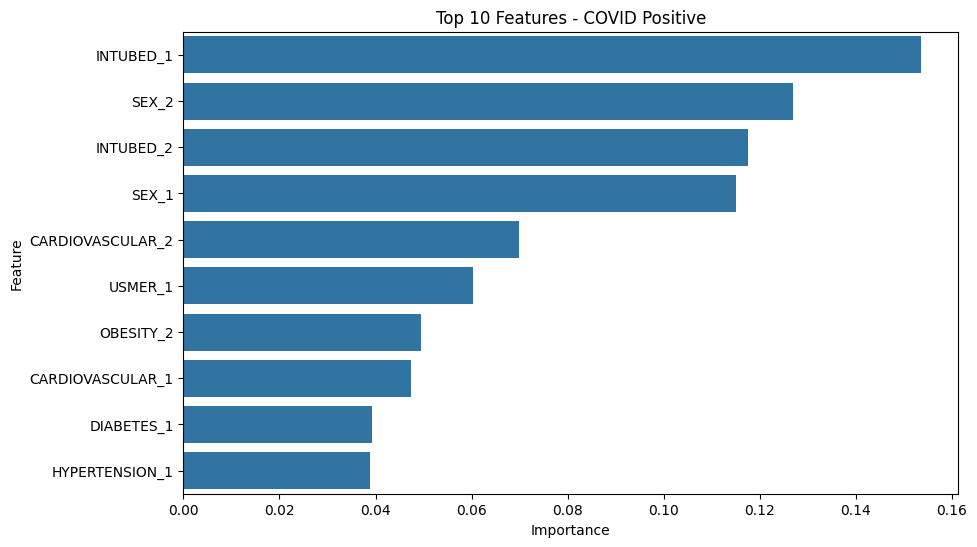

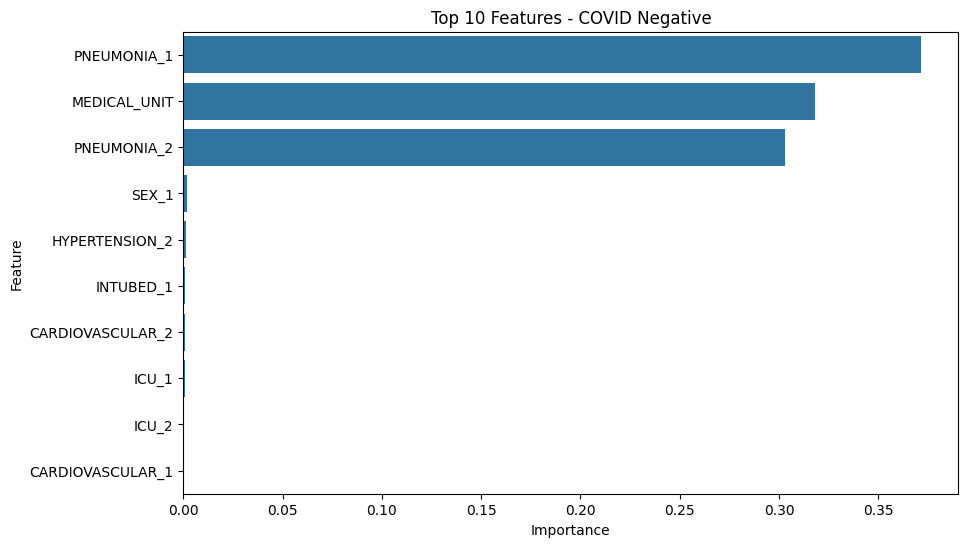

In [40]:
def plot_feature_importance(X, y, model, title):
    """Plot feature importance for the best model."""
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', model)])
    pipeline.fit(X, y)
    categorical_transformer = pipeline.named_steps['preprocessor'].named_transformers_['cat']
    if hasattr(categorical_transformer.named_steps['onehot'], 'get_feature_names_out'):
        cat_features = categorical_transformer.named_steps['onehot'].get_feature_names_out(categorical_features)
    else:
        cat_features = categorical_transformer.named_steps['onehot'].get_feature_names(categorical_features)
    all_features = numeric_features + list(cat_features)
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    elif hasattr(model, 'coef_'):
        importances = np.abs(model.coef_)
    else:
        print(f"Cannot extract feature importance for {type(model).__name__}")
        return
    # Create DataFrame and sort
    feature_importance = pd.DataFrame({
        'Feature': all_features,
        'Importance': importances
    }).sort_values('Importance', ascending=False)
    # Plot top 10 features
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', 
                data=feature_importance.head(10))
    plt.title(f'Top 10 Features - {title}')
    plt.show()
    return feature_importance

# COVID pos
best_model_pos = RandomForestRegressor(n_estimators=100, max_depth=10)
pos_feature_importance = plot_feature_importance(
    covid_pos[features], covid_pos[target], 
    best_model_pos, "COVID Positive")
# COVID neg
best_model_neg = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1)
neg_feature_importance = plot_feature_importance(
    covid_neg[features], covid_neg[target], 
    best_model_neg, "COVID Negative")